### 获取20类新闻数据集

In [83]:
from sklearn.datasets import fetch_20newsgroups

train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=33)
test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=33)

#filenames target_names target data 
print(train_data.filenames[0])
print(train_data.target_names)
print(train_data.target[0])
print(train_data.data[0])
print(type(train_data.data))

/Users/didi/scikit_learn_data/20news_home/20news-bydate-train/sci.space/61121
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
14
From: xrcjd@mudpuppy.gsfc.nasa.gov (Charles J. Divine)
Subject: Space Station Redesign Chief Resigns for Health Reasons
Organization: NASA/GSFC Greenbelt Maryland
Lines: 12

Writer Kathy Sawyer reported in today's Washington Post that Joseph Shea, the 
head of the space station redesign has resigned for health reasons.

Shea was hospitalized shortly after his selection in February.  He returned
yesterday to lead the formal presentation to the independent White House panel.
Shea's presentation was rambling and almost ina

### 数据可视化

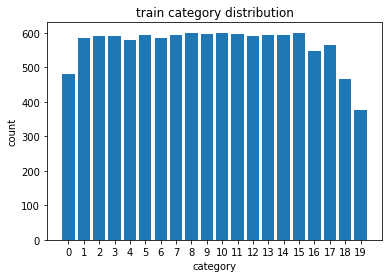

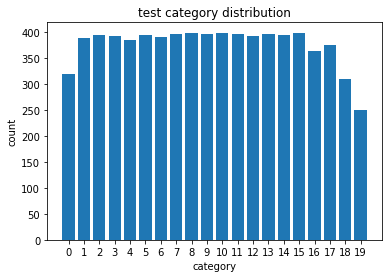

In [84]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

def category_distribution(data, title):
    distribution = Counter(data.target)
    xVals = list(distribution.keys())
    yVals = list(distribution.values())
    plt.title(title)
    plt.xlabel("category")
    plt.ylabel("count")
    plt.xticks(xVals)
    plt.bar(xVals, yVals, align='center', alpha=1)
    plt.show()
    
category_distribution(train_data, "train category distribution")
category_distribution(test_data, "test category distribution")

由上图可知，20类新闻包是一个分类平衡的数据集。

In [85]:
import numpy as np

def get_word_count_list(data):
    word_count_list = []
    for doc in data:
        word_count_list.append(len(doc.split()))
    return word_count_list

def word_count_info(word_count_list, data_name):
    print("max word count of the {} data is {}".format(data_name, np.max(word_count_list)))
    print("mean word count of the {} data is {}".format(data_name, np.mean(word_count_list)))
    print("median word count of the {} data is {}".format(data_name, np.median(word_count_list)))

train_word_list = get_word_count_list(train_data.data)
test_word_list = get_word_count_list(test_data.data)
word_count_info(train_word_list, "train")
word_count_info(test_word_list, "test")

max word count of the train data is 11821
mean word count of the train data is 287.4701255082199
median word count of the train data is 176.0
max word count of the test data is 9578
mean word count of the test data is 277.92671269251196
median word count of the test data is 173.0


由上图可知，训练集和测试集文档词条数统计信息相似。

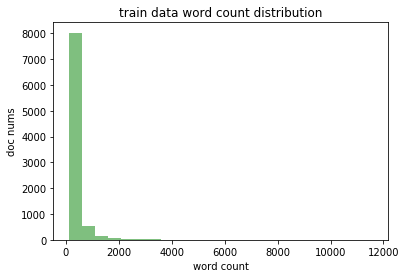

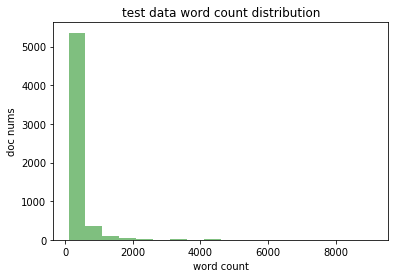

In [86]:
def word_count_distribution(word_count_list, desc):
    plt.hist(word_count_list, bins=range(100,np.max(word_count_list),500), color="green", alpha=0.5)
    plt.xlabel('word count')
    plt.ylabel('doc nums')
    plt.title('{} word count distribution'.format(desc))
    plt.show()
word_count_distribution(train_word_list, "train data")
word_count_distribution(test_word_list, "test data")

可以看出训练集和测试集文档的单词数绝大部分都是集中在500以上，一小部分在500到1000，其余单词数的文档所占比重极小。

### 数据预处理
1. 去掉文档的headers、footers、quotes
2. 定义文本预处理过滤器，去掉数字、标点符号及其他非法字符，统一单词为小写形式

In [87]:
import re

train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=33, remove=("headers", "footers"))
test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=33, remove=("headers", "footers"))

def data_filter(content):
    return re.sub('[\d\W]+', ' ', content.lower()).strip()

print(data_filter(train_data.data[0]))

writer kathy sawyer reported in today s washington post that joseph shea the head of the space station redesign has resigned for health reasons shea was hospitalized shortly after his selection in february he returned yesterday to lead the formal presentation to the independent white house panel shea s presentation was rambling and almost inaudible shea s deputy former astronaut bryan o connor will take over the effort goldin asserted that the redesign effort is on track


### 特征提取

#### 1. Tf-Idf
利用参数stop_words移除停用词

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor=data_filter, stop_words='english')
tfidf_train = tfidf.fit_transform(train_data.data)
tfidf_test = tfidf.transform(test_data.data)
print(type(tfidf_train[0]))

<class 'scipy.sparse.csr.csr_matrix'>


#### 2. Word2Vec

2.1 利用20newsgroups训练Word2Vec

In [89]:
from gensim.models import *

dim = 200

all_news = fetch_20newsgroups(subset='all')

In [90]:
sentences = [data_filter(text).split() for text in all_news.data]
w2v_model = Word2Vec(sentences, workers=4, min_count=1, size=dim, iter=10)
w2v_model.save('word2vec_model')

In [91]:
w2v_model = Word2Vec.load('word2vec_model')
w2v_model.wv.most_similar('post')

[('posts', 0.5684540271759033),
 ('repost', 0.5561078786849976),
 ('followup', 0.5318762063980103),
 ('posted', 0.5278148651123047),
 ('responses', 0.5219321250915527),
 ('comment', 0.517927348613739),
 ('postings', 0.5134007930755615),
 ('newsgroup', 0.5119473934173584),
 ('summarize', 0.501715898513794),
 ('topic', 0.49728184938430786)]

2.2 利用text8训练Word2Vec

In [92]:
import zipfile
import os
from urllib.request import urlretrieve

def data_download(url, filename):
    if not os.path.exists(filename):
        filename,_ = urlretrieve(url+filename,filename)
    else:
        print("{} has already existed".format(filename))
    return filename

text8 = data_download('http://mattmahoney.net/dc/', 'text8.zip')

def load_txts(fpath):
    fz = zipfile.ZipFile(fpath,'r')
    for file in fz.namelist():
        fz.extract(file)
    fz.close()
text8 = load_txts('text8.zip')

text8.zip has already existed


In [93]:
#训练Word2Vec
text =  word2vec.Text8Corpus('text8')
w2v_model2 = Word2Vec(text,  workers=4, min_count=1, size=dim, iter=10)
w2v_model2.save('word2vec_model2')

In [94]:
w2v_model2 = Word2Vec.load('word2vec_model2')
w2v_model2.wv.most_similar("post")

[('pre', 0.4767377972602844),
 ('audial', 0.413959801197052),
 ('wigry', 0.4079519510269165),
 ('bitos', 0.403106153011322),
 ('elta', 0.40089792013168335),
 ('gymnopaidiai', 0.3968144357204437),
 ('era', 0.39261382818222046),
 ('vngry', 0.3865062892436981),
 ('unrationalizable', 0.3854973018169403),
 ('office', 0.3850465416908264)]

### 机器学习分类模型
#### 定义评估指标函数，划分出训练集和验证集

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X = tfidf_train
y = train_data.target
test_true = test_data.target

X_train, X_verified, y_train, y_verified = train_test_split(X, y, random_state=10, test_size=0.1)

def evaluate_model(model):
    model_name = model.__class__.__name__
    y_pred = model.predict(X_verified)
    tfidf_pred = model.predict(tfidf_test)
    print("accuracy score of {} on the validation set is {}".format(model_name, accuracy_score(y_verified, y_pred)))
    print("accuracy score of {} on the test set is {}".format(model_name, accuracy_score(test_true, tfidf_pred)))

#### 基准模型 决策树+tfidf

In [96]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
evaluate_model(tree_model)

accuracy score of DecisionTreeClassifier on the validation set is 0.5980565371024735
accuracy score of DecisionTreeClassifier on the test set is 0.5058417419012214


#### 朴素贝叶斯+tfidf

In [97]:
from sklearn.naive_bayes import MultinomialNB

bayes_model = MultinomialNB()
bayes_model.fit(X_train, y_train)
evaluate_model(bayes_model)

accuracy score of MultinomialNB on the validation set is 0.8277385159010601
accuracy score of MultinomialNB on the test set is 0.7697822623473181


#### 支持向量机+tfidf

In [98]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=10)
svm_model.fit(X_train, y_train)
evaluate_model(svm_model)

accuracy score of LinearSVC on the validation set is 0.8842756183745583
accuracy score of LinearSVC on the test set is 0.7947424322889007


### 调优机器学习分类模型
利用网格搜索法GridSearchCV和k折交叉验证法KFold来优化贝叶斯和支持向量机模型，寻找模型最佳参数

#### 调优朴素贝叶斯

In [99]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer

scoring_fnc = make_scorer(accuracy_score)
kfold = KFold(n_splits=10, random_state=10)

parameters = {'alpha': [round(0.01*i, 3) for i in range(1, 100, 5)]}
bayes_grid = GridSearchCV(bayes_model, parameters, scoring_fnc, cv=kfold)
bayes_grid.fit(X_train, y_train)
best_bayes = bayes_grid.best_estimator_

evaluate_model(best_bayes)
for key in parameters.keys():
    print('{}: {}'.format(key, best_bayes.get_params()[key]))

accuracy score of MultinomialNB on the validation set is 0.8763250883392226
accuracy score of MultinomialNB on the test set is 0.8007169410515136
alpha: 0.01


#### 调优支持向量机

In [100]:
C = [0.1*i for i in range(1, 20, 2)]
tol = [0.001, 0.01, 0.1]
parameters = {'C': C, 'tol': tol}
svm_grid = GridSearchCV(svm_model, parameters, cv=kfold)
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

evaluate_model(best_svm)
for key in parameters.keys():
    print('{}: {}'.format(key, best_svm.get_params()[key]))

accuracy score of LinearSVC on the validation set is 0.8851590106007067
accuracy score of LinearSVC on the test set is 0.7954062665958577
C: 0.7000000000000001
tol: 0.001


### 神经网络CNN分类模型+Word2Vec
1. 20newsgroups训练的Word2Vec

In [101]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split

MAX_SEQUENCE_LENGTH = 300
MAX_NUM_WORDS = 15000
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(all_news.data)
sequences = tokenizer.texts_to_sequences(all_news.data)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(all_news.target))
x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(data, labels, test_size=0.2, random_state=33)

In [102]:
def get_embedding_matrix(wv):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items(): 
        if word in wv:
            embedding_matrix[i] = np.asarray(wv[word], dtype='float32')
    return embedding_matrix

def cnn_train(wv):
    embedding_matrix = get_embedding_matrix(wv)
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(64, 3, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Flatten()(x)
    preds = Dense(labels.shape[1], activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    his = model.fit(x_cnn_train, y_cnn_train, validation_split=0.2, epochs=20, batch_size=128)
    result = model.evaluate(x_cnn_test, y_cnn_test)
    return his, result

def cnn_train_optimizer(wv):
    embedding_matrix = get_embedding_matrix(wv)
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(64, 3, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(EMBEDDING_DIM, activation='relu')(x)
    preds = Dense(labels.shape[1], activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    his = model.fit(x_cnn_train, y_cnn_train, validation_split=0.2, epochs=20, batch_size=128)
    result = model.evaluate(x_cnn_test, y_cnn_test)
    return his, result

In [103]:
his, result = cnn_train(w2v_model.wv)
print(result)

Train on 12060 samples, validate on 3016 samples
Epoch 1/20
12060/12060 [==============================] - 23s 2ms/step - loss: 2.7769 - acc: 0.2185 - val_loss: 1.8206 - val_acc: 0.3883
Epoch 2/20
12060/12060 [==============================] - 23s 2ms/step - loss: 1.2088 - acc: 0.6129 - val_loss: 1.4391 - val_acc: 0.5249
Epoch 3/20
12060/12060 [==============================] - 23s 2ms/step - loss: 0.6727 - acc: 0.8013 - val_loss: 1.4059 - val_acc: 0.5550
Epoch 4/20
12060/12060 [==============================] - 24s 2ms/step - loss: 0.3990 - acc: 0.8939 - val_loss: 1.4553 - val_acc: 0.5647
Epoch 5/20
12060/12060 [==============================] - 23s 2ms/step - loss: 0.2315 - acc: 0.9512 - val_loss: 1.4637 - val_acc: 0.5716
Epoch 6/20
12060/12060 [==============================] - 22s 2ms/step - loss: 0.1346 - acc: 0.9803 - val_loss: 1.5549 - val_acc: 0.5666
Epoch 7/20
12060/12060 [==============================] - 24s 2ms/step - loss: 0.0747 - acc: 0.9942 - val_loss: 1.6309 - val_acc:

In [104]:
his1, result1 = cnn_train_optimizer(w2v_model.wv)
print(result1)

Train on 12060 samples, validate on 3016 samples
Epoch 1/20
12060/12060 [==============================] - 25s 2ms/step - loss: 3.0510 - acc: 0.1095 - val_loss: 2.4908 - val_acc: 0.1857
Epoch 2/20
12060/12060 [==============================] - 24s 2ms/step - loss: 1.9593 - acc: 0.3401 - val_loss: 1.6161 - val_acc: 0.4436
Epoch 3/20
12060/12060 [==============================] - 24s 2ms/step - loss: 1.3016 - acc: 0.5601 - val_loss: 1.3657 - val_acc: 0.5279
Epoch 4/20
12060/12060 [==============================] - 25s 2ms/step - loss: 1.0058 - acc: 0.6598 - val_loss: 1.2279 - val_acc: 0.5782
Epoch 5/20
12060/12060 [==============================] - 24s 2ms/step - loss: 0.7948 - acc: 0.7362 - val_loss: 1.1793 - val_acc: 0.5925
Epoch 6/20
12060/12060 [==============================] - 24s 2ms/step - loss: 0.6353 - acc: 0.7869 - val_loss: 1.1969 - val_acc: 0.5968
Epoch 7/20
12060/12060 [==============================] - 24s 2ms/step - loss: 0.5054 - acc: 0.8316 - val_loss: 1.2544 - val_acc:

In [105]:
his, result = cnn_train(w2v_model2.wv)
print(result)

Train on 12060 samples, validate on 3016 samples
Epoch 1/20
12060/12060 [==============================] - 22s 2ms/step - loss: 2.9414 - acc: 0.1671 - val_loss: 2.1602 - val_acc: 0.2971
Epoch 2/20
12060/12060 [==============================] - 21s 2ms/step - loss: 1.5197 - acc: 0.5153 - val_loss: 1.7825 - val_acc: 0.4138
Epoch 3/20
12060/12060 [==============================] - 21s 2ms/step - loss: 0.8715 - acc: 0.7409 - val_loss: 1.6583 - val_acc: 0.4741
Epoch 4/20
12060/12060 [==============================] - 22s 2ms/step - loss: 0.5294 - acc: 0.8572 - val_loss: 1.6873 - val_acc: 0.4864
Epoch 5/20
12060/12060 [==============================] - 22s 2ms/step - loss: 0.3196 - acc: 0.9289 - val_loss: 1.7586 - val_acc: 0.4997
Epoch 6/20
12060/12060 [==============================] - 23s 2ms/step - loss: 0.2023 - acc: 0.9649 - val_loss: 1.8319 - val_acc: 0.5043
Epoch 7/20
12060/12060 [==============================] - 22s 2ms/step - loss: 0.1322 - acc: 0.9830 - val_loss: 1.8665 - val_acc:

In [106]:
his, result = cnn_train_optimizer(w2v_model2.wv)
print(result)

Train on 12060 samples, validate on 3016 samples
Epoch 1/20
12060/12060 [==============================] - 25s 2ms/step - loss: 3.2806 - acc: 0.0755 - val_loss: 2.9313 - val_acc: 0.1041
Epoch 2/20
12060/12060 [==============================] - 24s 2ms/step - loss: 2.5064 - acc: 0.2135 - val_loss: 1.9940 - val_acc: 0.3299
Epoch 3/20
12060/12060 [==============================] - 25s 2ms/step - loss: 1.6668 - acc: 0.4436 - val_loss: 1.6660 - val_acc: 0.4400
Epoch 4/20
12060/12060 [==============================] - 24s 2ms/step - loss: 1.2711 - acc: 0.5806 - val_loss: 1.4721 - val_acc: 0.5013
Epoch 5/20
12060/12060 [==============================] - 24s 2ms/step - loss: 0.9938 - acc: 0.6726 - val_loss: 1.4728 - val_acc: 0.5169
Epoch 6/20
12060/12060 [==============================] - 24s 2ms/step - loss: 0.8002 - acc: 0.7339 - val_loss: 1.4483 - val_acc: 0.5305
Epoch 7/20
12060/12060 [==============================] - 26s 2ms/step - loss: 0.6313 - acc: 0.7971 - val_loss: 1.4727 - val_acc:

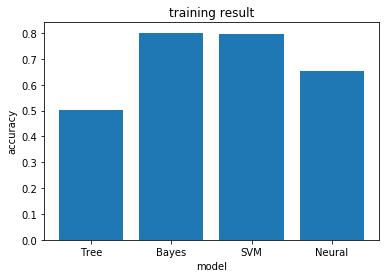

In [107]:
models = ["Tree", "Bayes", "SVM", "Neural"]
scores = [0.503, 0.801, 0.795, 0.652]
plt.title("training result")
plt.xlabel("model")
plt.ylabel("accuracy")
plt.bar(range(len(scores)), scores, tick_label = models, align='center', alpha=1)
plt.show()

Text(0,0.5,'score')

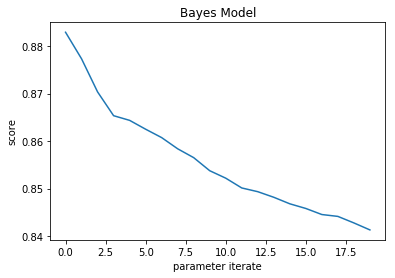

In [108]:
plt.plot(bayes_grid.cv_results_['mean_test_score'])
plt.title('Bayes Model')
plt.xlabel('parameter iterate')
plt.ylabel('score')